In [4]:
import math
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import numpy as np
import cartopy.feature as cfeature
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
import glob
import datetime as dt
from netCDF4 import date2num,num2date
#from scipy.ndimage import gaussian_filter


In [5]:
#Open HYCOM 25
#ds_25 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_084_*_3z.nc', combine = 'by_coords', concat_dim = 'time')
#ds_25.to_netcdf('test_25.nc')
#ds25 = xr.open_dataset('test_25.nc')

#ds_26 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_085_*_3z.nc', combine = 'by_coords', concat_dim = 'time')
#ds_26.to_netcdf('test_26.nc')
#ds26 = xr.open_dataset('test_26.nc')

#ds_25 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_084_*_3z.nc')#, combine = 'by_coords', concat_dim = 'time')
#ds_25.to_netcdf('test_25.nc')
#ds25 = xr.open_dataset('test_25.nc')


d01 = xr.open_dataset('/Users/Anna/Desktop/WRF/shortRunSST/wrfinput_d01')
d02 = xr.open_dataset('/Users/Anna/Desktop/WRF/shortRunSST/wrfinput_d02')
d03 = xr.open_dataset('/Users/Anna/Desktop/WRF/shortRunSST/wrfinput_d03')

print(d01.variables)
print('n', d02.variables)
print('n', d03.variables)

OSError: [Errno -101] NetCDF: HDF error: 'C:\\Users\\Anna\\Desktop\\WRF\\shortRunSST\\wrfinput_d03'

In [3]:
#test domain
#latbounds = [26.5, 27]
#lonbounds = [-91, -90.5]

#real domain 
latbounds = [24, 29]
lonbounds = [-93, -87]

lats = ds25.Latitude.values[:]
lons = ds25.Longitude.values[:]

#set upper & lower bounds
latli = np.argmin(np.abs(lats-latbounds[0]))
latui = np.argmin(np.abs(lats-latbounds[1]))
lonli = np.argmin(np.abs(lons-lonbounds[0]))
lonui = np.argmin(np.abs(lons-lonbounds[1]))

SST_subset_25=ds25.variables['water_temp'][:,0,latli:latui, lonli:lonui]
#SST_subset_26=ds26.variables['water_temp'][:,0,latli:latui, lonli:lonui]

lat_array=ds25.Latitude.values[latli:latui]
lon_array=ds25.Longitude.values[lonli:lonui]

meanSST_25 = SST_subset_25.mean('MT')
#meanSST_26 = SST_subset_26.mean('MT')


In [4]:
#Gaussian Filter SST25
#HYCOM: lat_array (Y), lon_array (X), meanU_25
#DS: goodUarr25_1-10, lat25_1, lon25_1s

HYCOM_lat = lat_array
HYCOM_lon = lon_array

#Define new grid: 1km (1000m)
#match WRF refernce lat/lon, increment by partial degree 
###### !!!!! wrf lat lon NEED TO UPDATE THESE !!!!! ######

#REAL CASE: 
lat_0 =  24.5
lon_0 = -93
lat_max = 28.5
lon_max = -87.5

#TEST CASE
#lat_0 =  26.5
#lon_0 = -91
#lat_max = 27
#lon_max = -90.5 

#min, max, then increment and fill lat & then lon (Y=lat, X=lon)
#0.008 degrees = 1km 
WRF_lat = np.arange(lat_0, lat_max, 0.00898315)
WRF_lon = np.arange(lon_0, lon_max, 0.00898315)
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)

#make current arrays (u & v) that match lat & lon dimensions, fill with nans 
sst25_WRF  = np.zeros((WRF_latLen, WRF_lonLen))   #(813, 688)
#sst26_WRF = np.zeros((WRF_latLen, WRF_lonLen))  
sst25_WRF[:] = -999
#sst26_WRF[:] = -999

#at equator, 1deg = 111.31949077920639km, so 1km*(1deg/111.31949077920639km) = 0.00898315
#Great Circle Calculator 
#http://edwilliams.org/gccalc.htm

#DS sigma??? = 0.03 # 0.015*2   
km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 # 0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 0.75 #0.5-1.0 
sigma_DS_km = sigma_DS*km_per_deg


for y in range (0, WRF_latLen):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_sst25HYCOM = 0
       
        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])       
        
        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
            
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                    weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM
                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_sst25HYCOM = sum_product_sst25HYCOM + weight_HYCOM * meanSST_25[lat_indices[y_small], lon_indices[x_small]]
                #sum_product_sst26HYCOM = sum_product_sst26HYCOM + weight_HYCOM * meanSST_26[lat_indices[y_small], lon_indices[x_small]]
                
    #outside of loop: sum of products/sum of weights
        sst25_WRF[y,x] = sum_product_sst25HYCOM/sum_weight_HYCOM
        #sst26_WRF[y,x] = sum_product_sst26HYCOM/sum_weight_HYCOM
        
        #difference
        #u25 diff = sum_weight hycom/weight hycom - sum weight DS/weight DS # (if beforehand) may need to test that none are missing, 
        #see distribution of differences as histogram, wide dist =bias, tight at mean = little bias
        #u25_diff = (sum_weight_HYCOM/weight_HYCOM) - ((sum_weight_DS25u1/weight_DS25u1)+(sum_weight_DS25u2/weight_DS25u2)+(sum_weight_DS25u3/weight_DS25u3)+(sum_weight_DS25u4/weight_DS25u4)+(sum_weight_DS25u5/weight_DS25u5)+(sum_weight_DS25u6/weight_DS25u6)+(sum_weight_DS25u7/weight_DS25u7)+(sum_weight_DS25u8/weight_DS25u8)+(sum_weight_DS25u9/weight_DS25u9)+(sum_weight_DS25u10/weight_DS25u10))


In [6]:
print('SST shape: ', sst25_WRF.shape)
print('lat shape: ', WRF_lat.shape)
print('lon shape: ', WRF_lon.shape)
print(sst25_WRF)

for x in sst25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in sst25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')

SST shape:  (446, 613)
lat shape:  (446,)
lon shape:  (613,)
[[23.01348171 23.01327358 23.01299109 ... 26.43642112 26.43649952
  26.43658447]
 [23.01348165 23.01327353 23.01299108 ... 26.43642108 26.43649949
  26.43654217]
 [23.01689967 23.01651091 23.01575337 ... 26.43644375 26.43652113
  26.43656305]
 ...
 [21.6268218  21.62996015 21.63406793 ... 22.39241626 22.38060327
  22.37424438]
 [21.6261244  21.62949841 21.63367855 ... 22.39058406 22.37882697
  22.37207554]
 [21.62583346 21.62907792 21.63332388 ... 22.38954511 22.37722382
  22.37010961]]


C:\Users\Anna\anaconda3\envs\metpy\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


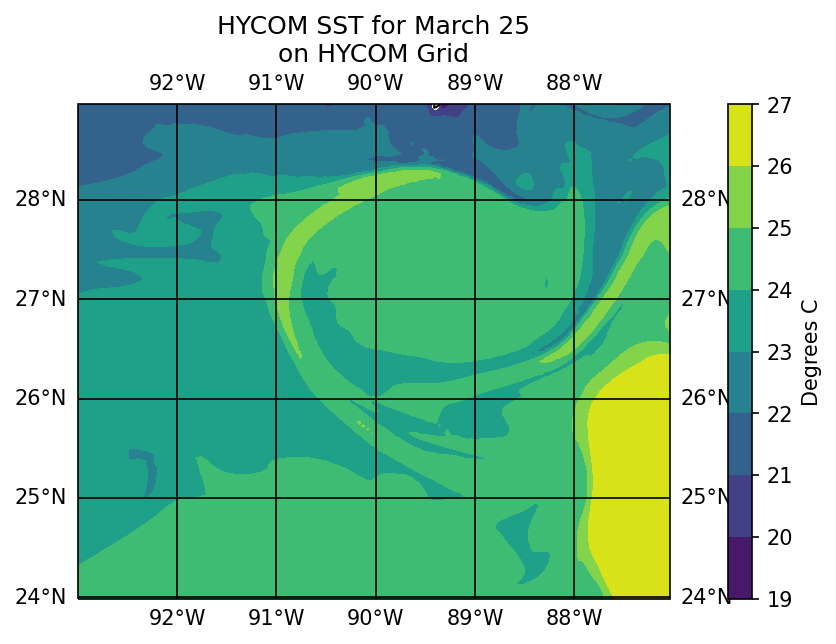

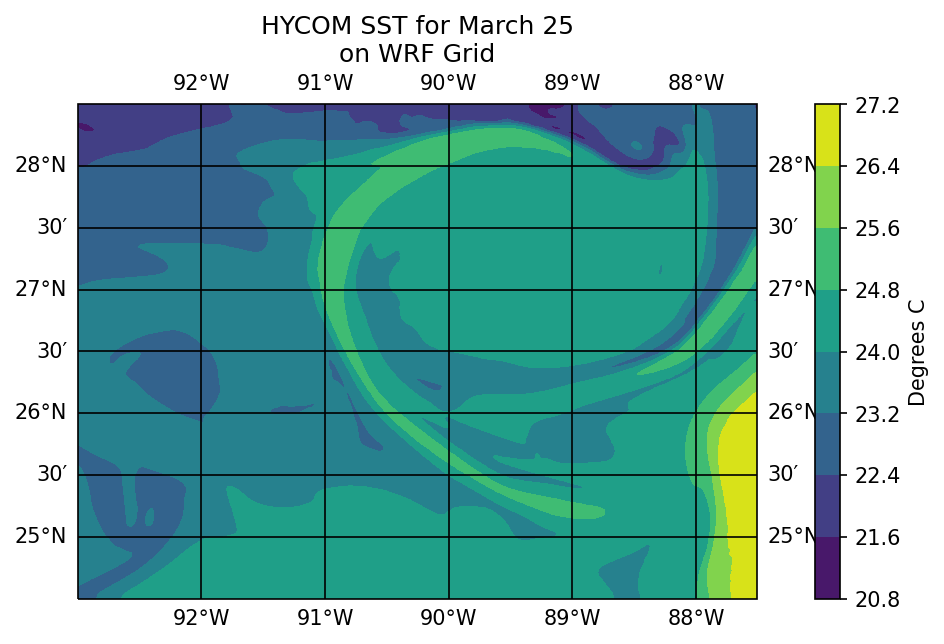

In [6]:
#SST25
mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(lon_array, lat_array, meanSST_25)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, label = 'Degrees C')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('HYCOM SST for March 25\non HYCOM Grid')

plt.show()
#SST25 smooth
mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(WRF_lon, WRF_lat, sst25_WRF)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, label = 'Degrees C')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
save_results_to = '/Users/Anna/Desktop/MSMET/Thesis/Writing/Plots/'
plt.savefig(save_results_to + '25SST_Weighted.png', bbox_inches = 'tight',dpi = 150)
plt.title('HYCOM SST for March 25\non WRF Grid')
plt.show()

In [10]:
#NETCDF TEST

#OPEN FILE, CREATE NEW DATASET
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = nc.Dataset('/Users/Anna/Desktop/MSMET/Thesis/newSST.nc', mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)

#CREATING DIMENSIONS
lat_dim = ncfile.createDimension('lat', 446)     # latitude axis
lon_dim = ncfile.createDimension('lon', 613)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print('dim: ', dim)

#CREATING ATTRIBUTES
#ncfile.title='My model data'
ncfile.title='WRF_test_input'
print('ncfile title: ', ncfile.title)

#ncfile.subtitle="My model data subtitle"
ncfile.subtitle="SST"
print('ncfile subtitle', ncfile.subtitle)
print('ncfile: ', ncfile)

#CREATING VARIABLES
# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'hours since 1800-01-01'
time.long_name = 'time'
print('\nlat shape: ', lat.shape)
print('lon shape: ', lon.shape)
# Define a 3D variable to hold the data
#temp = ncfile.createVariable('temp',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
#temp.units = 'K' # degrees Kelvin
#temp.standard_name = 'air_temperature' # this is a CF standard name
#print(temp)
sst = ncfile.createVariable('SST', np.float64, ('time','lat','lon')) # note: unlimited dimension is leftmost
sst.units = 'C' # degrees Kelvin
sst.standard_name = 'sea surface temperature' # this is a CF standard name
print(sst)
sst[:,:] = sst25_WRF
print('\nsst:', sst[:,:])

#PREDEFINED VARIABLES
#print("-- Some pre-defined attributes for variable temp:")
#print("temp.dimensions:", temp.dimensions)
#print("temp.shape:", temp.shape)
#print("temp.dtype:", temp.dtype)
#print("temp.ndim:", temp.ndim)
print("\n-- Some pre-defined attributes for variable sst:")
print("sst.dimensions:", sst.dimensions)
print("sst.shape:", sst.shape)
print("sst.dtype:", sst.dtype)
print("sst.ndim:", sst.ndim)

#WRITING DATA
#nlats = len(lat_dim); nlons = len(lon_dim); ntimes = 3
# Write latitudes, longitudes.
# Note: the ":" is necessary in these "write" statements
#lat[:] = -90. + (180./nlats)*np.arange(nlats) # south pole to north pole
#lon[:] = (180./nlats)*np.arange(nlons) # Greenwich meridian eastward
# create a 3D array of random numbers
#data_arr = np.random.uniform(low=280,high=330,size=(ntimes,nlats,nlons))
# Write the data.  This writes the whole 3D netCDF variable all at once.
#temp[:,:,:] = data_arr  # Appends data along unlimited dimension
#print("-- Wrote data, temp.shape is now ", temp.shape)
# read data back from variable (by slicing it), print min and max
#print("-- Min/Max values:", temp[:,:,:].min(), temp[:,:,:].max())

#nlats = len(lat_dim); nlons = len(lon_dim); ntimes = 3
# Write latitudes, longitudes.
# Note: the ":" is necessary in these "write" statements
#lat[:] = -90. + (180./nlats)*np.arange(nlats) # south pole to north pole
#lon[:] = (180./nlats)*np.arange(nlons) # Greenwich meridian eastward
lat[:] = WRF_lat 
lon[:]= WRF_lon
print('\nlats:', lat[:])
print('lons;', lon[:])
# create a 3D array of random numbers
#data_arr = np.random.uniform(low=280,high=330,size=(ntimes,nlats,nlons))
# Write the data.  This writes the whole 3D netCDF variable all at once.
#u_current[:,:,:] = data_arr  # Appends data along unlimited dimension
#print("-- Wrote data, u_current.shape is now ", u_current.shape)
# read data back from variable (by slicing it), print min and max
#print("-- Min/Max values:", u_current[:,:,:].min(), u_current[:,:,:].max())
'''
# create a 2D array of random numbers
#data_slice = np.random.uniform(low=280,high=330,size=(nlats,nlons))
#temp[3,:,:] = data_slice   # Appends the 4th time slice
print("-- Wrote more data, u_current.shape is now ", u_current.shape)
# create a 2D array of random numbers
data_slice = np.random.uniform(low=280,high=330,size=(nlats,nlons))
u_current[3,:,:] = data_slice   # Appends the 4th time slice
print("-- Wrote more data, u_current.shape is now ", u_current.shape)
'''
print('\ntime:', time[:])
times_arr = time[:]
print(type(times_arr),times_arr)  # dashes indicate masked values (where data has not yet been written)

# 1st 4 days of October.
#dates = [dt.datetime(2014,10,1,0),dt.datetime(2014,10,2,0),dt.datetime(2014,10,3,0),dt.datetime(2014,10,4,0)]
#print(dates)
dates = [dt.datetime(2018,3,25,0)]
print('\ndate:', dates[0])
times = date2num(dates, time.units)
print(times, time.units) # numeric values
time[:] = times
# read time data back, convert to datetime instances, check values.
print(time[:])
print(time.units)
print(num2date(time[:],time.units))

#CLOSING NETCDF
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('\nDataset is closed!')


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
dim:  ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 446)
dim:  ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 613)
dim:  ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
ncfile title:  WRF_test_input
ncfile subtitle SST
ncfile:  <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: WRF_test_input
    subtitle: SST
    dimensions(sizes): lat(446), lon(613), time(0)
    variables(dimensions): 
    groups: 

lat shape:  (446,)
lon shape:  (613,)
<class 'netCDF4._netCDF4.Variable'>
float64 SST(time, lat, lon)
    units: C
    standard_name: sea surface temperature
unlimited dimensions: time
current shape = (0, 446, 613)
filling on, default _FillValue of 9.969209968386869e+36 used

u_currents: [[[23.01348171 2

C:\Users\Anna\anaconda3\envs\metpy\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


In [ ]:
'''
#Gaussian Filter SST25
#HYCOM: lat_array (Y), lon_array (X), meanU_25
#DS: goodUarr25_1-10, lat25_1, lon25_1s

HYCOM_lat = lat_array
HYCOM_lon = lon_array

#Define new grid: 1km (1000m)
#match WRF refernce lat/lon, increment by partial degree 
###### !!!!! wrf lat lon NEED TO UPDATE THESE !!!!! ######

#REAL CASE: 
lat_0 =  24.5
lon_0 = -93
lat_max = 28.9
lon_max = -87.5
#TEST CASE
#lat_0 =  26.5
#lon_0 = -91
#lat_max = 27
#lon_max = -90.5 

#min, max, then increment and fill lat & then lon (Y=lat, X=lon)
#0.008 degrees = 1km 
WRF_lat = np.arange(lat_0, lat_max, 0.00898315)
WRF_lon = np.arange(lon_0, lon_max, 0.00898315)
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)

#make current arrays (u & v) that match lat & lon dimensions, fill with nans 
#sst25_WRF  = np.zeros((WRF_latLen, WRF_lonLen))   #(813, 688)
sst26_WRF = np.zeros((WRF_latLen, WRF_lonLen))  
#sst25_WRF[:] = -999
sst26_WRF[:] = -999

#at equator, 1deg = 111.31949077920639km, so 1km*(1deg/111.31949077920639km) = 0.00898315
#Great Circle Calculator 
#http://edwilliams.org/gccalc.htm

#DS sigma??? = 0.03 # 0.015*2   
km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 # 0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg

for y in range (0, WRF_latLen):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
        #print('x:', x)
        sum_weight_HYCOM = 0
        #sum_product_u25HYCOM = 0
        sum_product_sst26HYCOM = 0
       
        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])       

        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
            
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                    weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM
                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                #sum_product_sst25HYCOM = sum_product_sst25HYCOM + weight_HYCOM * meanSST_25[lat_indices[y_small], lon_indices[x_small]]
                sum_product_sst26HYCOM = sum_product_sst26HYCOM + weight_HYCOM * meanSST_26[lat_indices[y_small], lon_indices[x_small]]
                
    #outside of loop: sum of products/sum of weights
        #sst25_WRF[y,x] = sum_product_sst25HYCOM/sum_weight_HYCOM
        sst26_WRF[y,x] = sum_product_sst26HYCOM/sum_weight_HYCOM
'''

In [ ]:
'''
print(sst26_WRF.shape)
print(sst26_WRF)
'''

In [ ]:
'''
#SST26
mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(lon_array, lat_array, meanSST_26)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, label = 'Degrees C')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('HYCOM SST for March 26\non HYCOM Grid')
plt.show()
#SST26 smooth 
mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(WRF_lon, WRF_lat, sst26_WRF)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, label = 'Degrees C')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
save_results_to = '/Users/Anna/Desktop/MSMET/Thesis/Writing/Plots/'
plt.savefig(save_results_to + '26SST_Weighted.png', bbox_inches = 'tight',dpi = 150)
plt.title('HYCOM SST for March 26\non WRF Grid')
plt.show()
'''